In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drug-dataset/Medicine_Details.csv


# Phase 1: Data Preprocessing and Exploration

## 1. Load and Inspect Data

### * Checking for missing values, duplicates, and inconsistencies
### * Examining column distributions and unique value counts for each feature.


In [2]:
import pandas as pd

# Load the dataset
file_path = '/kaggle/input/drug-dataset/Medicine_Details.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)


In [3]:
# Inspect the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11825 entries, 0 to 11824
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Medicine Name       11825 non-null  object
 1   Composition         11825 non-null  object
 2   Uses                11825 non-null  object
 3   Side_effects        11825 non-null  object
 4   Image URL           11825 non-null  object
 5   Manufacturer        11825 non-null  object
 6   Excellent Review %  11825 non-null  int64 
 7   Average Review %    11825 non-null  int64 
 8   Poor Review %       11825 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 831.6+ KB
None


In [4]:
print(data.describe(include='all'))

        Medicine Name            Composition  \
count           11825                  11825   
unique          11498                   3358   
top     Lulifin Cream  Luliconazole (1% w/w)   
freq                4                     98   
mean              NaN                    NaN   
std               NaN                    NaN   
min               NaN                    NaN   
25%               NaN                    NaN   
50%               NaN                    NaN   
75%               NaN                    NaN   
max               NaN                    NaN   

                                         Uses  \
count                                   11825   
unique                                    712   
top     Treatment of Type 2 diabetes mellitus   
freq                                      907   
mean                                      NaN   
std                                       NaN   
min                                       NaN   
25%                            

In [5]:
print(data.head())

              Medicine Name  \
0   Avastin 400mg Injection   
1  Augmentin 625 Duo Tablet   
2       Azithral 500 Tablet   
3          Ascoril LS Syrup   
4         Aciloc 150 Tablet   

                                         Composition  \
0                                Bevacizumab (400mg)   
1    Amoxycillin  (500mg) +  Clavulanic Acid (125mg)   
2                               Azithromycin (500mg)   
3  Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...   
4                                 Ranitidine (150mg)   

                                                Uses  \
0   Cancer of colon and rectum Non-small cell lun...   
1                  Treatment of Bacterial infections   
2                  Treatment of Bacterial infections   
3                      Treatment of Cough with mucus   
4  Treatment of Gastroesophageal reflux disease (...   

                                        Side_effects  \
0  Rectal bleeding Taste change Headache Noseblee...   
1  Vomiting Nausea Diarrhea

## 2. Handle Missing Values
### * Imputing the missing values or remove rows/columns with excessive null values. For text data filling missing values with "Unknown"

In [6]:
# Check missing values
missing_values = data.isnull().sum()
print(missing_values)

Medicine Name         0
Composition           0
Uses                  0
Side_effects          0
Image URL             0
Manufacturer          0
Excellent Review %    0
Average Review %      0
Poor Review %         0
dtype: int64


In [7]:
# Fill missing values
data['Composition'] = data['Composition'].fillna('Unknown')
data['Side_effects'] = data['Side_effects'].fillna('Unknown')


## 3. Normalize Text Data
### * Standardize text in columns like Composition, Side_effects, and Uses:
### * Convert to lowercase.
### * Remove special characters and stopwords.
### * Tokenize if necessary.

In [8]:
import re

#  Function for text cleaning
def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text


In [9]:
# Apply text cleaning
data['Composition'] = data['Composition'].apply(clean_text)
data['Side_effects'] = data['Side_effects'].apply(clean_text)
data['Uses'] = data['Uses'].apply(clean_text)


# 4. Explore Key Features
### * Analyze the distribution of medications by:
#### * Manufacturer.
#### * Use cases.
#### * Review ratings.
#### * Identify outliers and anomalies.

In [10]:
# Manufacturer distribution
print(data['Manufacturer'].value_counts())


Manufacturer
Sun Pharmaceutical Industries Ltd    820
Intas Pharmaceuticals Ltd            654
Cipla Ltd                            574
Torrent Pharmaceuticals Ltd          445
Lupin Ltd                            435
                                    ... 
Universal NutriScience                 1
Orison Pharma International            1
Pacific Biotech                        1
Misae Lifesciences Pvt Ltd             1
Albia Biocare                          1
Name: count, Length: 759, dtype: int64


In [11]:
# Review rating analysis
review_columns = ['Excellent Review %', 'Average Review %', 'Poor Review %']
data[review_columns].describe()


,Excellent Review %,Average Review %,Poor Review %
count,11825.000000,11825.000000,11825.000000
mean,38.516025,35.756364,25.727611
std,25.225343,18.268134,23.991985
min,0.000000,0.000000,0.000000
25%,22.000000,27.000000,0.000000
50%,34.000000,35.000000,22.000000
75%,51.000000,47.000000,35.000000
max,100.000000,88.000000,100.000000


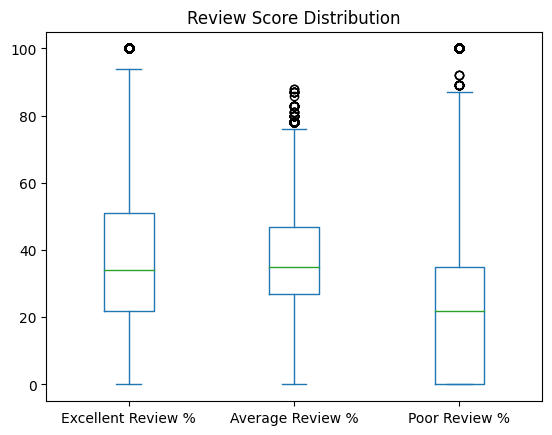

In [12]:
# Visualize rating distribution
import matplotlib.pyplot as plt

data[review_columns].plot(kind='box')
plt.title('Review Score Distribution')
plt.show()

## 5. Feature Engineering
###     Tokenize Symptoms and Side Effects:
####    *  Break these fields into individual tokens for embedding later.
###     Aggregate Reviews into Sentiment:
####    * Convert percentages into categorical labels (e.g., Positive, Neutral, Negative).

In [13]:
# Tokenize symptoms
data['Tokenized_Uses'] = data['Uses'].apply(lambda x: x.split())


In [14]:
# Aggregate review sentiment
def review_to_sentiment(row):
    if row['Excellent Review %'] > 50:
        return 'Positive'
    elif row['Poor Review %'] > 50:
        return 'Negative'
    else:
        return 'Neutral'

data['Review_Sentiment'] = data.apply(review_to_sentiment, axis=1)

# 6. Save Cleaned Data
### Store the cleaned dataset for use in subsequent phases.

In [15]:
cleaned_file_path = 'cleaned_dataset.csv'
data.to_csv(cleaned_file_path, index=False)
print(f"Cleaned data saved to {cleaned_file_path}")


Cleaned data saved to cleaned_dataset.csv


# Phase 2: Generate Embeddings and Build the Similarity Engine

## In this phase, we'll generate embeddings for textual data using Word2Vec and build a similarity engine to recommend medications.
## This engine will allow us to input symptoms or medical conditions and find relevant medications based on their uses, composition, and side effects.

## Step 1: Preprocess Text Data for Embeddings
### We need to combine and tokenize the relevant text fields (Uses, Composition, Side_effects) to prepare them for embedding generation.

In [16]:
# Combine relevant columns into a single text field
data['Combined_Text'] = data['Uses'] + ' ' + data['Composition'] + ' ' + data['Side_effects']

# Tokenize the combined text field
data['Tokenized_Text'] = data['Combined_Text'].apply(lambda x: x.split())


## Step 2: Train a Word2Vec Model
### Train a Word2Vec model on the tokenized text data to generate word embeddings for the vocabulary.

In [17]:
from gensim.models import Word2Vec

word2vec_model = Word2Vec(
    sentences=data['Tokenized_Text'], 
    vector_size=100, 
    window=5, 
    min_count=1, 
    workers=4
)


## Step 3: Generate Row Embeddings
#### Create an embedding for each row by averaging the embeddings of the words in the combined text field.

In [18]:
import numpy as np

# Function to generate row embeddings
def get_embedding(text_tokens):
    vectors = [word2vec_model.wv[word] for word in text_tokens if word in word2vec_model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

print("Generating embeddings...")
data['Embedding'] = data['Tokenized_Text'].apply(get_embedding)

# Convert embeddings to a numpy array for similarity calculations
embeddings_matrix = np.vstack(data['Embedding'].values)


Generating embeddings...


## Step 4: Build the Similarity Engine
### Implement a similarity engine that uses cosine similarity to find the most relevant medications for a given input.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
def find_similar_medicines(input_symptom, top_n=5):
    # Preprocess the input symptom
    input_tokens = clean_text(input_symptom)

    # Check if the model is loaded and ready
    if not hasattr(word2vec_model, 'wv'):
        raise NameError("Word2Vec model is not loaded properly")

    # Ensure that the input tokens exist in the model vocabulary
    input_vector = np.mean([word2vec_model.wv[token] for token in input_tokens if token in word2vec_model.wv], axis=0)

    # Calculate similarity with the 'Uses' column
    similarities = []
    for idx, row in data.iterrows():
        medicine_vector = np.mean([word2vec_model.wv[token] for token in clean_text(row['Uses']) if token in word2vec_model.wv], axis=0)
        sim_score = cosine_similarity([input_vector], [medicine_vector])
        similarities.append((sim_score[0][0], idx, row['Review_Sentiment']))  # Include sentiment in tuple

    # Sort primarily by sentiment, then by similarity score
    sentiment_order = {'Positive': 1, 'Neutral': 2, 'Negative': 3}
    similarities = sorted(similarities, key=lambda x: (sentiment_order[x[2]], -x[0]))  # Sort by sentiment and then by similarity score in descending order

    # Return the top N most similar medicines
    recommended_medicines = []
    for score, idx, sentiment in similarities[:top_n]:
        medicine = data.iloc[idx]
        medicine['Similarity_Score'] = score
        recommended_medicines.append(medicine)
    
    return recommended_medicines



In [20]:
# Example usage
sample_input = "Treatment of Parasitic infections"
print("\nTreatment Medications:")
recommended = find_similar_medicines(sample_input)
for med in recommended:
    print(med[['Medicine Name', 'Uses', 'Review_Sentiment', 'Similarity_Score']])


Treatment Medications:
Medicine Name                    Ivermect 12mg Tablet
Uses                treatment of parasitic infections
Review_Sentiment                             Positive
Similarity_Score                                  1.0
Name: 3865, dtype: object
Medicine Name                     Olworm 400mg Tablet
Uses                treatment of parasitic infections
Review_Sentiment                             Positive
Similarity_Score                                  1.0
Name: 7318, dtype: object
Medicine Name                    Vermact 12 Tablet DT
Uses                treatment of parasitic infections
Review_Sentiment                             Positive
Similarity_Score                                  1.0
Name: 10924, dtype: object
Medicine Name                                   Gravidol 200mg Tablet
Uses                 hypertension high blood pressure angina heart...
Review_Sentiment                                             Positive
Similarity_Score                       

<ipython-input-19-42e01bc5bd39>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medicine['Similarity_Score'] = score
<ipython-input-19-42e01bc5bd39>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medicine['Similarity_Score'] = score
<ipython-input-19-42e01bc5bd39>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medicine['Similarity_Score'] = score
<ipython-input-19-42e01bc5bd39>:28: SettingWithCopyWarning: 
A value is trying to 

In [21]:
# Example usage
sample_input = "Treatment of Diabetes Melitus"
print("\nTreatment Medications:")
recommended = find_similar_medicines(sample_input)
for med in recommended:
    print(med[['Medicine Name', 'Uses', 'Review_Sentiment', 'Similarity_Score']])


Treatment Medications:
Medicine Name                                     Minirin Nasal Spray
Uses                treatment of diabetes insipidustreatment of be...
Review_Sentiment                                             Positive
Similarity_Score                                             0.999206
Name: 5529, dtype: object
Medicine Name                                 Ansuper-Plus Capsule SR
Uses                treatment of gastroesophageal reflux disease a...
Review_Sentiment                                             Positive
Similarity_Score                                             0.996343
Name: 932, dtype: object
Medicine Name                                     Drego-LS Capsule SR
Uses                treatment of gastroesophageal reflux disease a...
Review_Sentiment                                             Positive
Similarity_Score                                             0.996343
Name: 1633, dtype: object
Medicine Name                             Enliva 20mg/75mg 

<ipython-input-19-42e01bc5bd39>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medicine['Similarity_Score'] = score
<ipython-input-19-42e01bc5bd39>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medicine['Similarity_Score'] = score
<ipython-input-19-42e01bc5bd39>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medicine['Similarity_Score'] = score
<ipython-input-19-42e01bc5bd39>:28: SettingWithCopyWarning: 
A value is trying to 

## Step 5: Save the Word2Vec Model
### Save the trained Word2Vec model for future use or integration.

In [22]:
# Save the Word2Vec model
word2vec_model_path = 'word2vec_medicine_model.model'
word2vec_model.save(word2vec_model_path)
print(f"\nWord2Vec model saved to {word2vec_model_path}")



Word2Vec model saved to word2vec_medicine_model.model
